# Statistics on basic predictors

We are going to limit ourselves to a few basic predictors and later try more advanced techniqes on these basic ones.

The predictors to be used are: DecisionTree, SVM and LogisticRegression.

here we are going to train each of the above predictors and show it's accuracy on a test dataset.

In [1]:
from Classifiers import ready_training_data
from Utilities.orginizers import LearningData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product
from random import sample
from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities

pool = Pool()
ld = LearningData()

In [80]:
stock_names = sample(ld.get_stock_names(), 5)
stocks = [ready_training_data(sn) for sn in stock_names]

AttributeError: 'tuple' object has no attribute 'describe'

In [81]:
print(stocks[0][0].describe())

            change        close  ex-divident         high          low  \
count  9980.000000  9980.000000  9980.000000  9980.000000  9980.000000   
mean      0.012228    45.946500     0.000586    46.527064    45.405153   
std       0.013521    23.097111     0.009222    23.447740    22.762305   
min       0.000000    10.260000     0.000000    10.660000     9.710000   
25%       0.003416    32.130000     0.000000    32.620000    31.880000   
50%       0.008791    40.500000     0.000000    41.000000    40.130000   
75%       0.016667    52.802500     0.000000    53.232500    52.402500   
max       0.217391   169.000000     0.180000   169.500000   165.500000   

              open  split_ratio        volume  change1_days_before  \
count  9980.000000  9980.000000  9.980000e+03          9980.000000   
mean     45.966606     1.000384  3.137148e+06             0.012228   
std      23.100762     0.023175  4.900818e+06             0.013521   
min       9.860000     1.000000  0.000000e+00        

In [3]:
def run_model(model):
    scores = {sn: [] for sn in stock_names}
    validation_rounds = 3
    for i in range(validation_rounds):
        for sn, (data, classes) in zip(stock_names, stocks):
            scores[sn].append(sum(cross_val_score(model, data, classes))/3) 
    for sn in scores.keys():
        scores[sn] = sum(scores[sn])/validation_rounds
    return scores

### Decision Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier

# create iterables for all options and use itertools product
criterion=['gini', 'entropy']
max_depth=[1, 2, 5, 10, None]
# using percentages
min_samples_leaf=[0.005, 0.01, 0.02, 0.05, 0.1]

models = [DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl) 
          for c, md, msl in product(criterion, max_depth, min_samples_leaf)]

In [66]:
accuracies = map(run_model, models)

In [67]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(models, accuracies):
    for sn, acc in accs.items():
        data.append((model.criterion, model.max_depth, model.min_samples_leaf, sn, acc))
results = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))

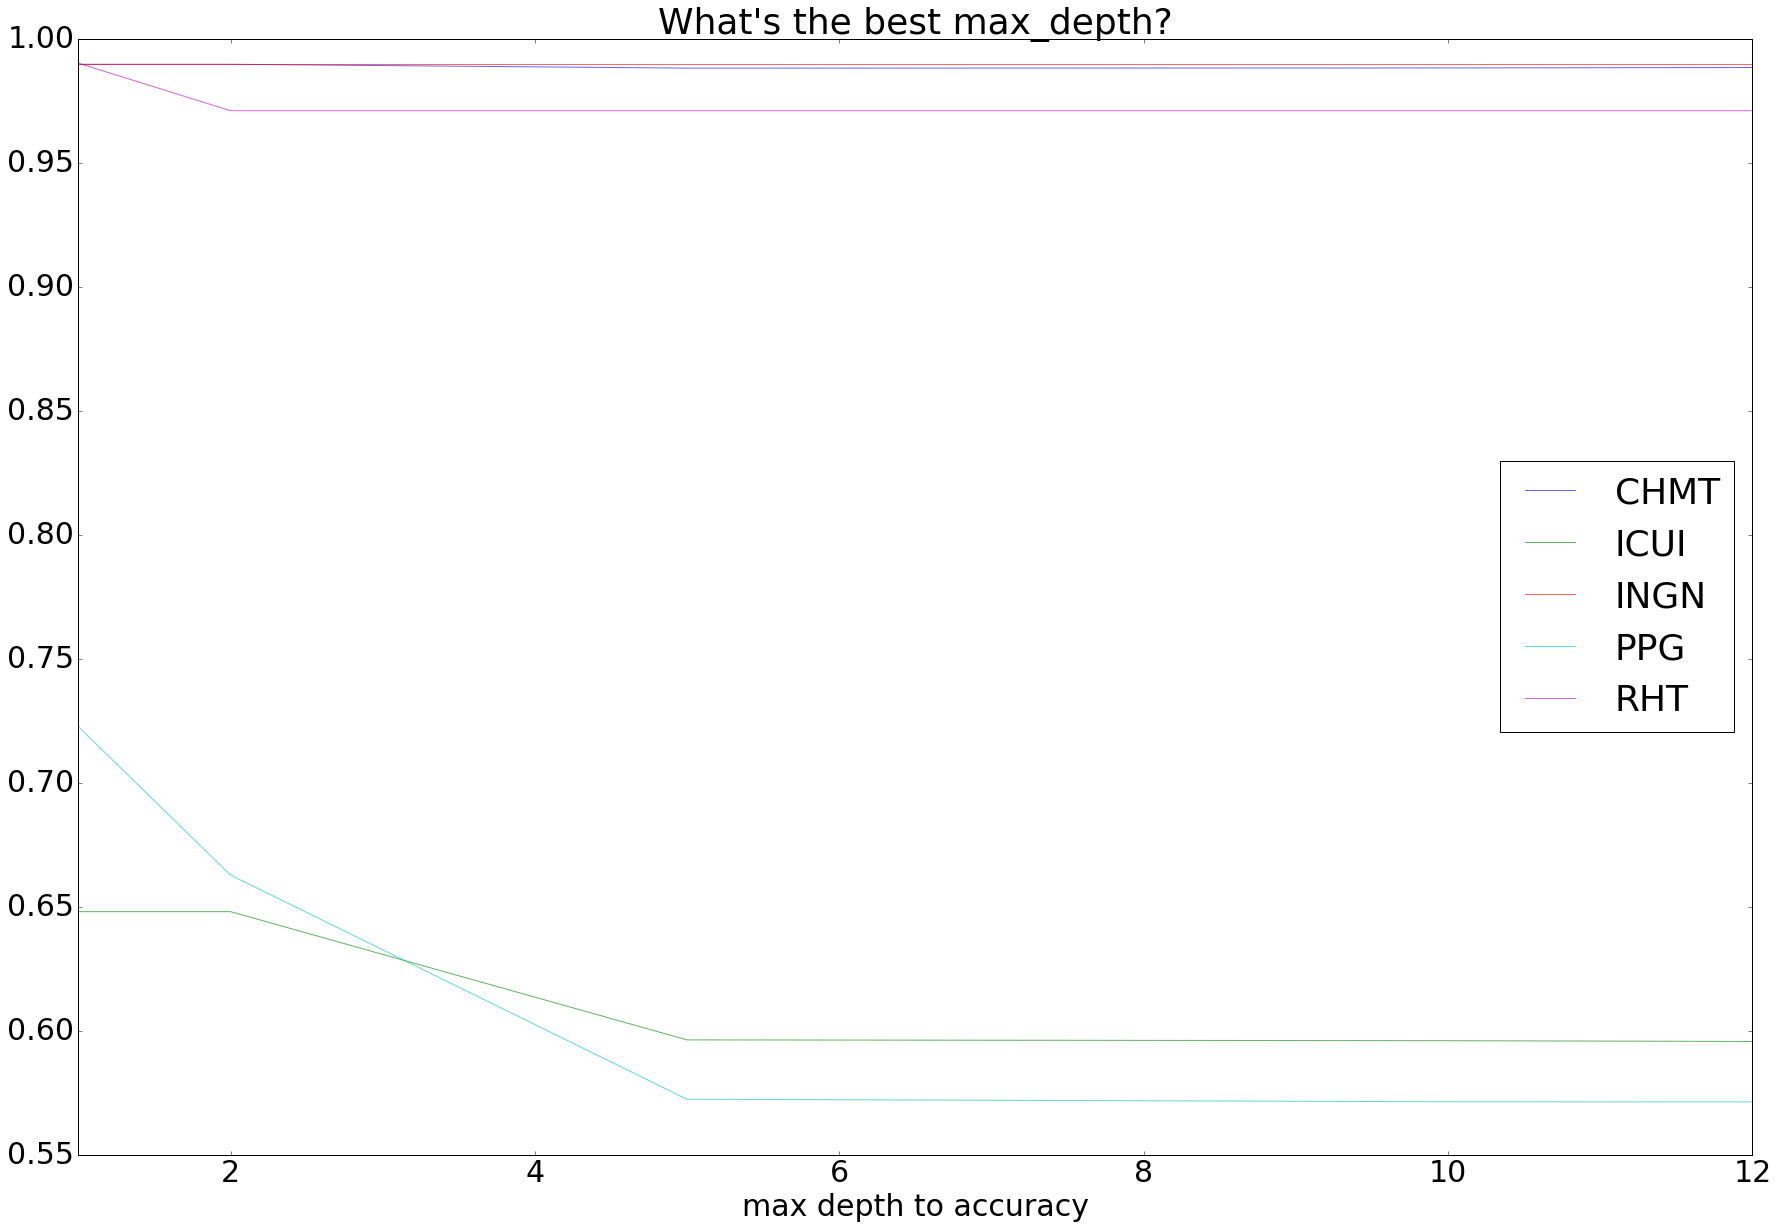

In [73]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('max_depth').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max depth to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

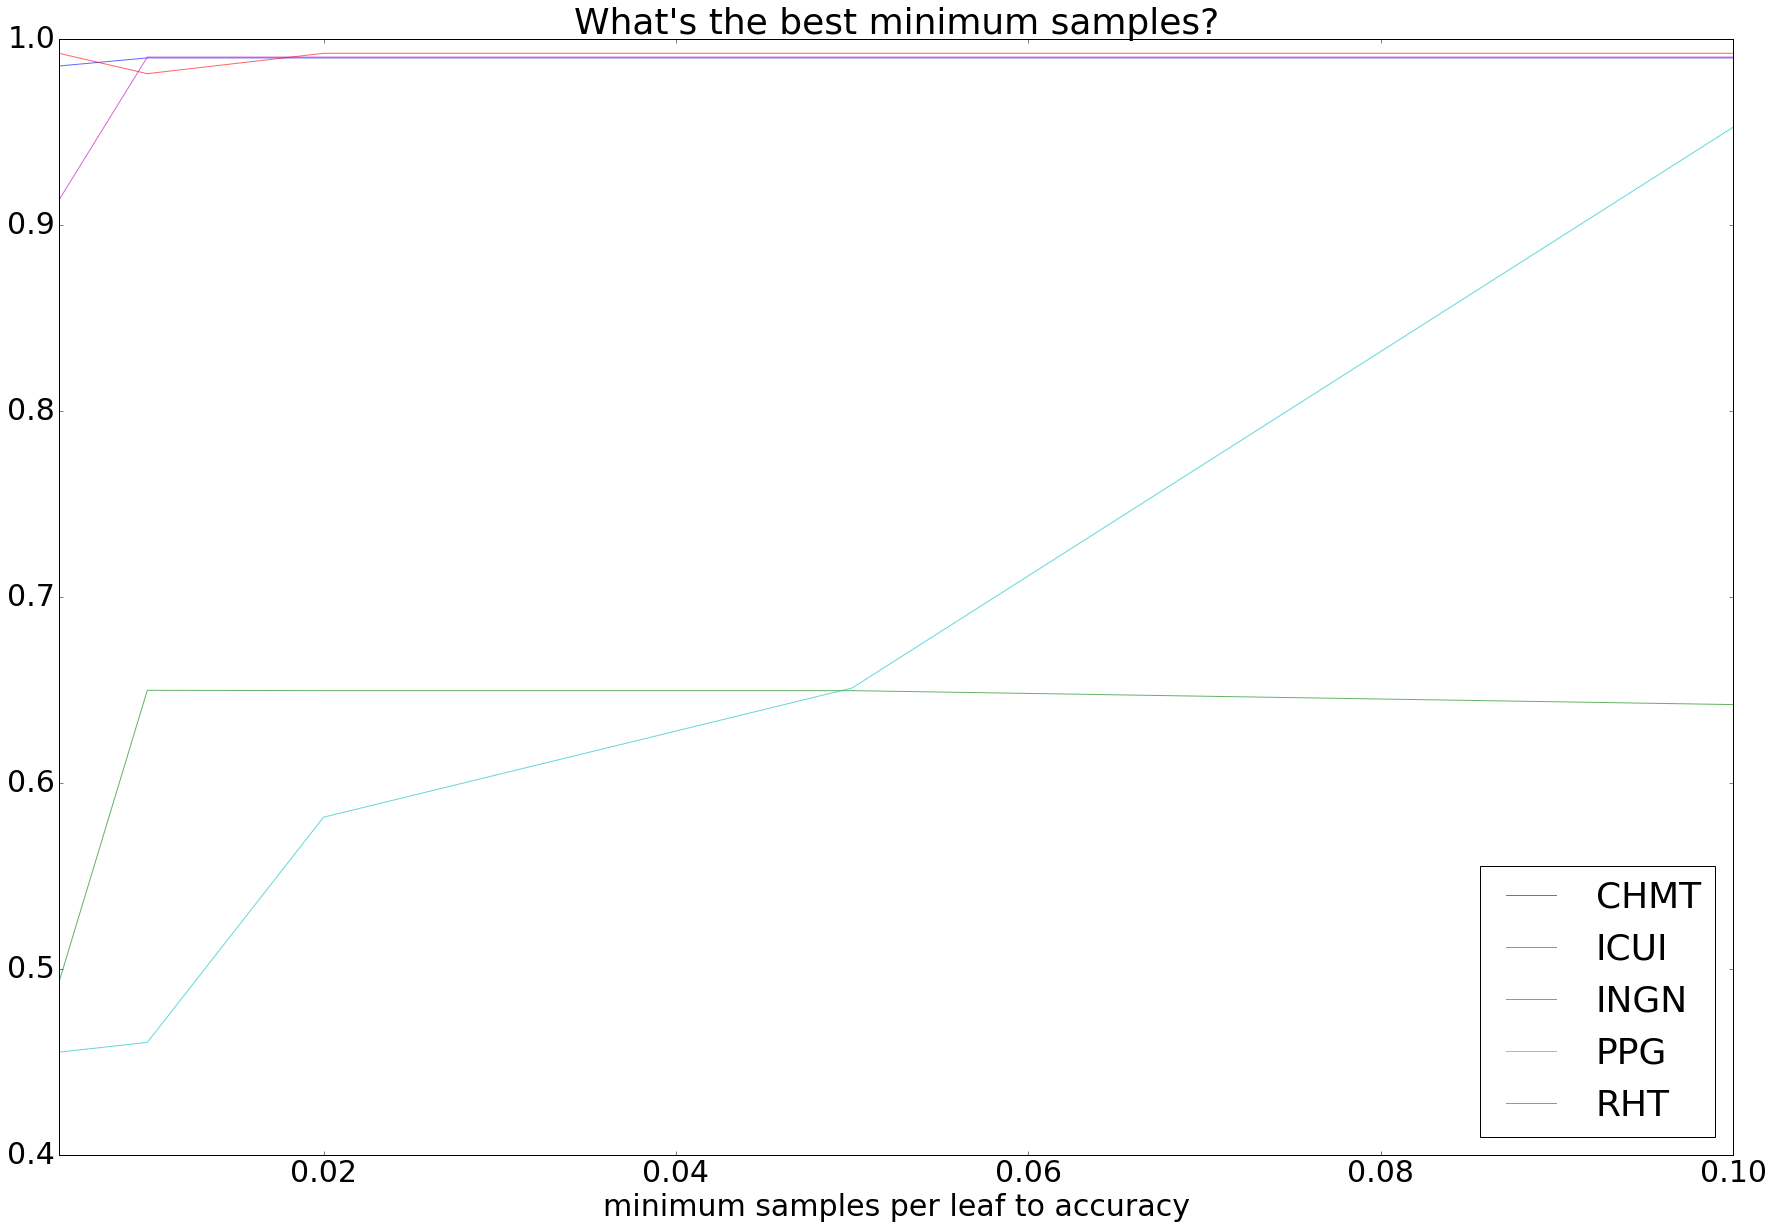

In [74]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('minimum samples per leaf to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best minimum samples?" )

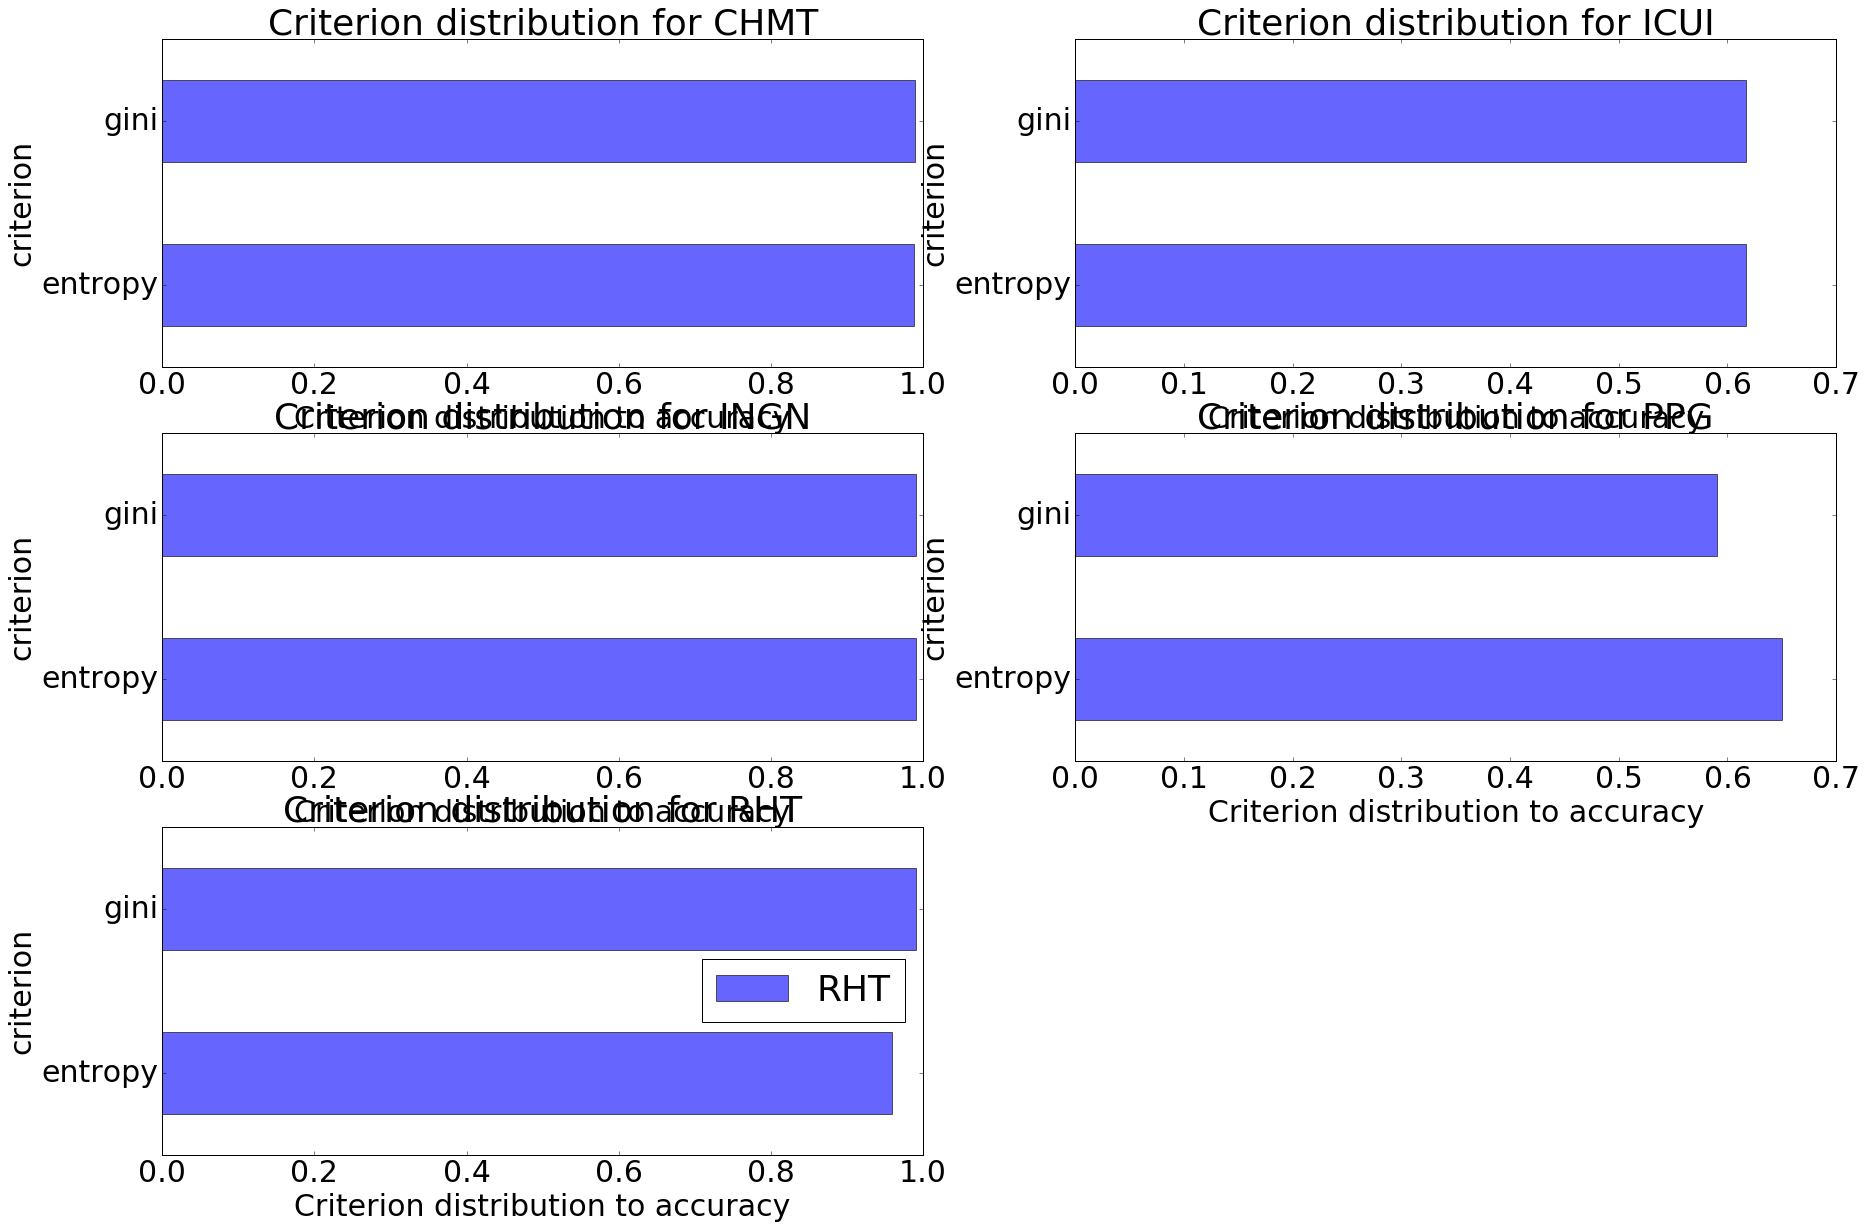

In [75]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution to accuracy')
    ax1.set_title("Criterion distribution for {}".format(name))
plt.legend(loc='best')


### SVM

In [76]:
from sklearn.svm import SVC

# create iterables for all options and use itertools product
C=[0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
kernel=['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
max_iter=[1, 2, 3, 5]

svm_models = [SVC(C=c, kernel=k, max_iter=mi) 
          for c, k, mi in product(C, kernel, max_iter)]

In [77]:
accuracies = map(run_model, svm_models)

In [79]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(svm_models, accuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.kernel, model.max_iter, sn, acc))
results = DataFrame(data, columns=('C', 'kernel', 'max_iter', 'stock', 'accuracy'))

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:220: Conv

ValueError: X should be a square kernel matrix